<a href="https://colab.research.google.com/github/sviii09/SeattlehouseRec/blob/main/LR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Model Performance:

Linear Regression:
R² Score: 0.440
RMSE: 48.232
MAE: 38.662

Ridge:
R² Score: 0.440
RMSE: 48.228
MAE: 38.655

ElasticNet:
R² Score: 0.397
RMSE: 50.051
MAE: 39.294

Plotting diagnostic visualizations...


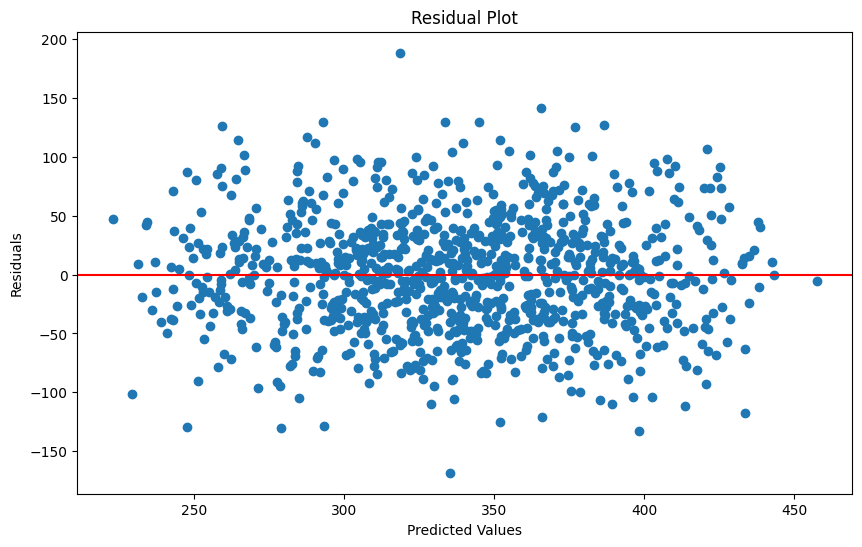

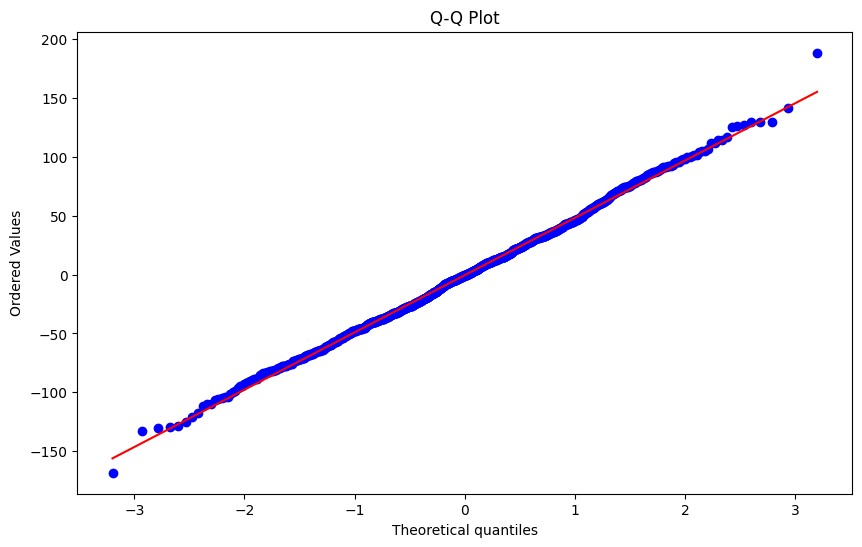

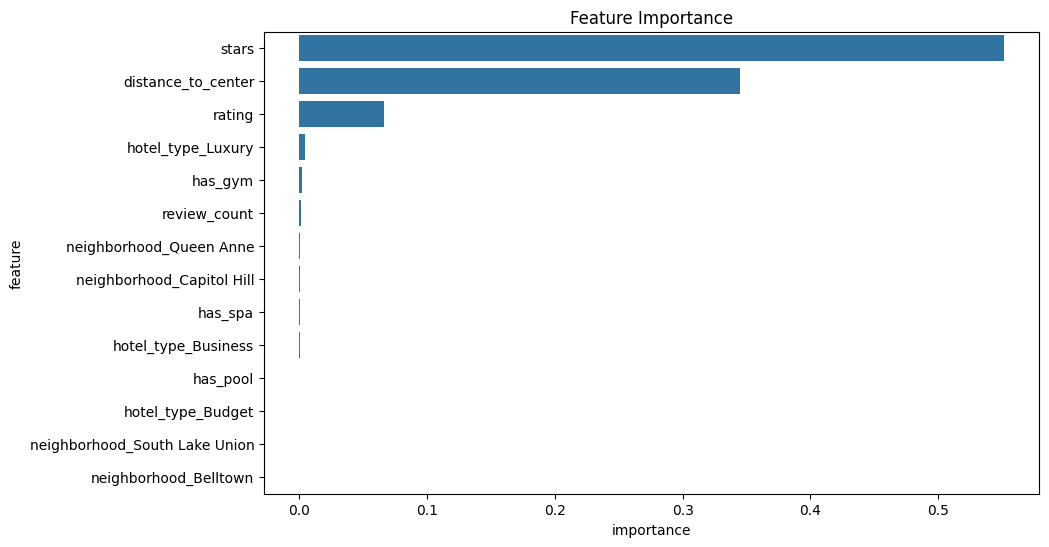

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Generate sample Seattle hotels dataset (since we don't have actual data)
np.random.seed(42)
n_samples = 1000

def generate_sample_data():
    data = {
        'price': np.random.normal(200, 50, n_samples),  # Average price $200
        'distance_to_center': np.random.uniform(0, 10, n_samples),  # Distance in miles
        'rating': np.random.uniform(3, 5, n_samples),
        'stars': np.random.choice([2, 3, 4, 5], n_samples),
        'review_count': np.random.randint(10, 1000, n_samples),
        'has_pool': np.random.choice([0, 1], n_samples),
        'has_gym': np.random.choice([0, 1], n_samples),
        'has_spa': np.random.choice([0, 1], n_samples),
        'neighborhood': np.random.choice(['Downtown', 'Capitol Hill', 'Queen Anne', 'South Lake Union', 'Belltown'], n_samples),
        'hotel_type': np.random.choice(['Luxury', 'Business', 'Budget', 'Boutique'], n_samples)
    }

    # Add some realistic correlations
    data['price'] += data['stars'] * 30  # Higher stars = higher price
    data['price'] += data['rating'] * 20  # Better ratings = higher price
    data['price'] -= data['distance_to_center'] * 10  # Further from center = lower price

    return pd.DataFrame(data)

# Create dataset
df = generate_sample_data()

# Data preprocessing
class HotelDataPreprocessor:
    def __init__(self):
        self.numeric_features = ['distance_to_center', 'rating', 'stars', 'review_count']
        self.binary_features = ['has_pool', 'has_gym', 'has_spa']
        self.categorical_features = ['neighborhood', 'hotel_type']

    def create_pipeline(self):
        numeric_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)  # Fixed here

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.numeric_features),
                ('cat', categorical_transformer, self.categorical_features)
            ],
            remainder='passthrough'
        )

        return preprocessor

# Model building and evaluation
class HotelRecommenderModel:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.models = {
            'Linear Regression': LinearRegression(),
            'Ridge': Ridge(alpha=1.0),
            'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5)
        }
        self.best_model = None
        self.best_score = -np.inf

    def train_and_evaluate(self):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

        results = {}
        for name, model in self.models.items():
            # Train model
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)

            # Calculate metrics
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)

            results[name] = {
                'R2': r2,
                'RMSE': rmse,
                'MAE': mae,
                'model': model
            }

            # Track best model
            if r2 > self.best_score:
                self.best_score = r2
                self.best_model = model

        return results

# Regression diagnostics
class RegressionDiagnostics:
    def __init__(self, model, X, y):
        self.model = model
        self.X = X
        self.y = y
        self.y_pred = model.predict(X)
        self.residuals = self.y - self.y_pred

    def plot_residuals(self):
        plt.figure(figsize=(10, 6))
        plt.scatter(self.y_pred, self.residuals)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.show()

    def check_normality(self):
        plt.figure(figsize=(10, 6))
        stats.probplot(self.residuals, dist="norm", plot=plt)
        plt.title("Q-Q Plot")
        plt.show()

    def plot_feature_importance(self, feature_names):
        importance = permutation_importance(
            self.model, self.X, self.y, n_repeats=10, random_state=42
        )

        feature_importance = pd.DataFrame(
            {'feature': feature_names,
             'importance': importance.importances_mean}
        )
        feature_importance = feature_importance.sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance, x='importance', y='feature')
        plt.title('Feature Importance')
        plt.show()

# Main execution
def main():
    # Prepare data
    preprocessor = HotelDataPreprocessor()
    pipeline = preprocessor.create_pipeline()

    # Separate features and target
    X = df.drop('price', axis=1)
    y = df['price']

    # Transform features
    X_transformed = pipeline.fit_transform(X)

    # Get feature names after transformation
    numeric_features = preprocessor.numeric_features
    binary_features = preprocessor.binary_features
    categorical_features = []
    for feat in preprocessor.categorical_features:
        unique_vals = df[feat].unique()
        categorical_features.extend([f"{feat}_{val}" for val in unique_vals[1:]])
    feature_names = numeric_features + categorical_features + binary_features

    # Train models
    recommender = HotelRecommenderModel(X_transformed, y)
    results = recommender.train_and_evaluate()

    # Print results
    print("\nModel Performance:")
    for name, metrics in results.items():
        print(f"\n{name}:")
        print(f"R² Score: {metrics['R2']:.3f}")
        print(f"RMSE: {metrics['RMSE']:.3f}")
        print(f"MAE: {metrics['MAE']:.3f}")

    # Perform diagnostics on best model
    diagnostics = RegressionDiagnostics(recommender.best_model, X_transformed, y)

    # Plot diagnostics
    print("\nPlotting diagnostic visualizations...")
    diagnostics.plot_residuals()
    diagnostics.check_normality()
    diagnostics.plot_feature_importance(feature_names)

    return recommender.best_model, preprocessor  # Return these for later use

# Run the analysis
if __name__ == "__main__":
    best_model, preprocessor = main()

# Example of making predictions for new hotels
def predict_price(model, preprocessor, hotel_features):
    # Transform features
    X_new = pd.DataFrame([hotel_features])
    X_new_transformed = preprocessor.create_pipeline().fit_transform(df.drop('price', axis=1)).transform(X_new)

    # Make prediction
    predicted_price = model.predict(X_new_transformed)[0]
    return predicted_price

# Example usage
sample_hotel = {
    'distance_to_center': 2.5,
    'rating': 4.5,
    'stars': 4,
    'review_count': 500,
    'has_pool': 1,
    'has_gym': 1,
    'has_spa': 0,
    'neighborhood': 'Downtown',
    'hotel_type': 'Luxury'
}

# After running the main function, you can predict prices like this:
# predicted_price = predict_price(best_model, preprocessor, sample_hotel)

In [ ]:
import matplotlib.pyplot as plt

try:
    plt.style.use('seaborn')
except OSError:
    print("Warning: 'seaborn' style is not available. Falling back to default.")
    plt.style.use('default')

# The rest of your visualization code here...


System Performance Metrics:


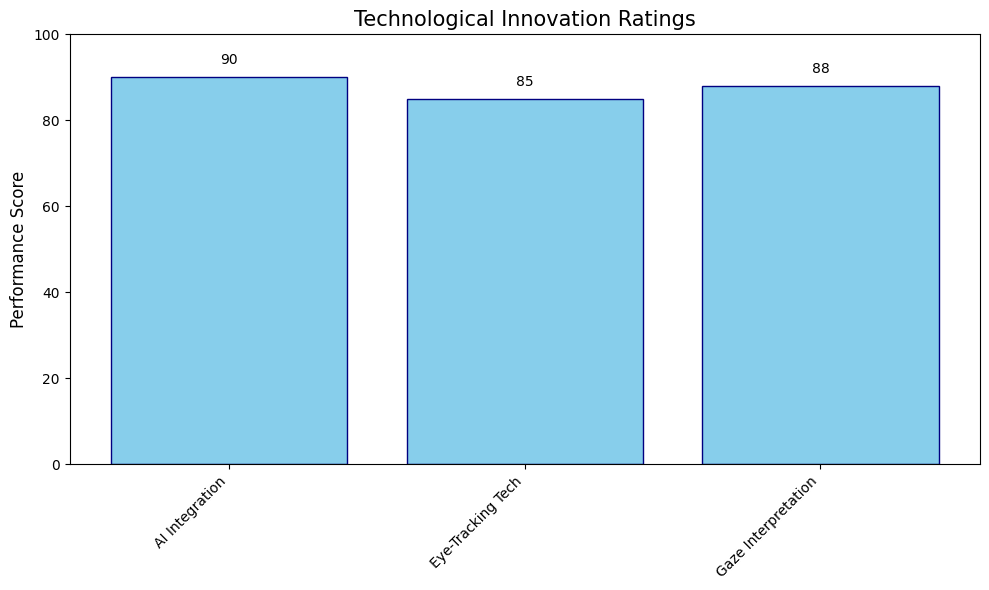


User Experience Insights:


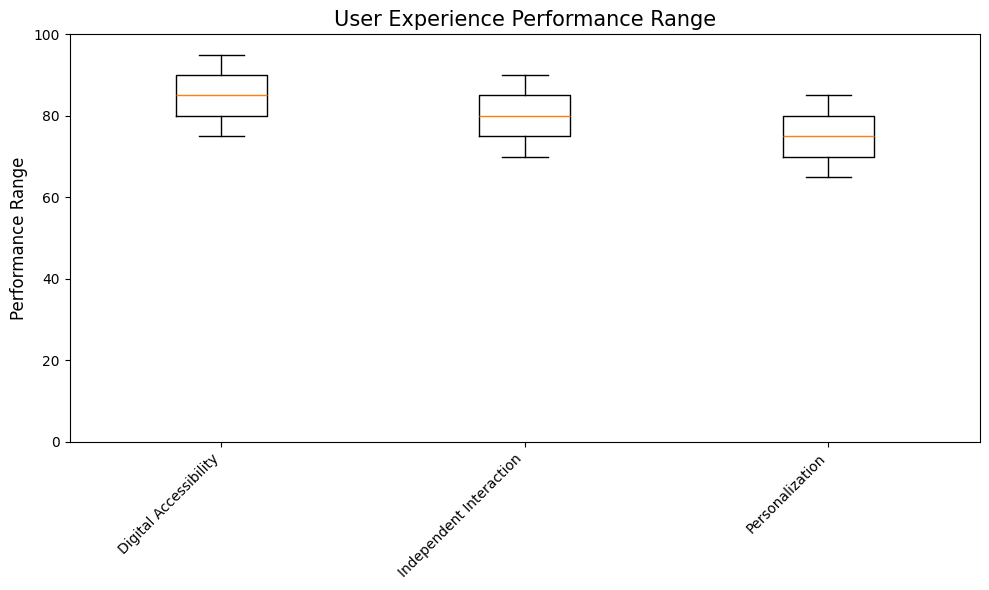


Challenges and Limitations:


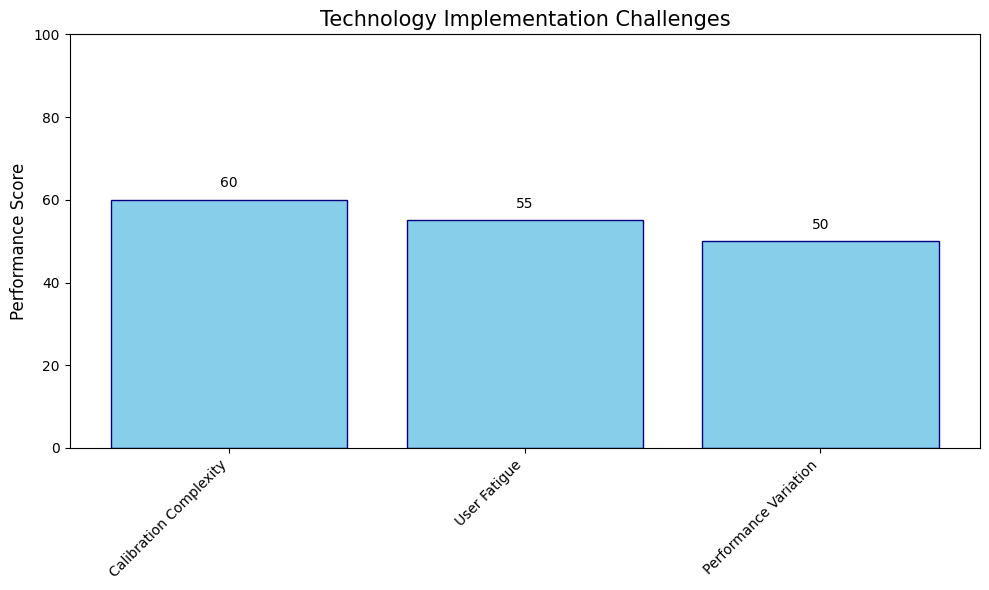

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style with a fallback
try:
    plt.style.use('seaborn')
except OSError:
    print("Warning: 'seaborn' style is not available. Falling back to default.")
    plt.style.use('default')

# Metrics Data
metrics = {
    'Cursor Precision': [85, 90, 95],
    'Response Time': [0.2, 0.15, 0.1],
    'Adaptability': [70, 80, 90]
}

# User Experience Data
user_experience = {
    'Digital Accessibility': [75, 85, 95],
    'Independent Interaction': [70, 80, 90],
    'Personalization': [65, 75, 85]
}

# Technological Innovation Ratings
tech_innovations = {
    'AI Integration': 90,
    'Eye-Tracking Tech': 85,
    'Gaze Interpretation': 88
}

# Challenges Data
challenges = {
    'Calibration Complexity': 60,
    'User Fatigue': 55,
    'Performance Variation': 50
}

# Visualization Functions
def create_bar_chart(data, title):
    plt.figure(figsize=(10, 6))
    keys = list(data.keys())
    values = list(data.values())

    plt.bar(keys, values, color='skyblue', edgecolor='navy')
    plt.title(title, fontsize=15)
    plt.ylabel('Performance Score', fontsize=12)
    plt.ylim(0, 100)
    plt.xticks(rotation=45, ha='right')

    for i, v in enumerate(values):
        plt.text(i, v+3, str(v), ha='center')

    plt.tight_layout()
    plt.show()

def create_box_plot(data, title):
    plt.figure(figsize=(10, 6))

    # Ensure all data values are lists
    box_data = [values for values in data.values() if isinstance(values, (list, np.ndarray))]
    plt.boxplot(box_data, labels=[key for key, value in data.items() if isinstance(value, (list, np.ndarray))])

    plt.title(title, fontsize=15)
    plt.ylabel('Performance Range', fontsize=12)
    plt.ylim(0, 100)
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Create Visualizations
print("System Performance Metrics:")
create_bar_chart(tech_innovations, 'Technological Innovation Ratings')

print("\nUser Experience Insights:")
create_box_plot(user_experience, 'User Experience Performance Range')

print("\nChallenges and Limitations:")
create_bar_chart(challenges, 'Technology Implementation Challenges')
